In [1]:
from HedgeFunctions import *
from AMM_Profit_Functions import * 
from Delta_Cutoffs import *
%load_ext autoreload
%autoreload 2
import datetime
ASSET = 'sETH'+'new'

df = pd.read_csv('{}.csv'.format(ASSET)) # import the new sETH data
df['DateTime'] = df.apply(lambda x: datetime.datetime.fromtimestamp(x['expiry']), axis = 1)
df = df[df.expiry > 1635235200] 
#df = df[df.expiry >1645390800] # use this for SOL
df_check = Checker(df.iloc[:])
check_arr = np.array(df_check)
round_starts = np.where(check_arr == 1)[0]
round_times = [df.iloc[round_starts[i]].expiry for i in range(0,len(round_starts))]

df_rounds = []
for i in range(0,len(round_starts)-1):
    df_dup = df.copy()
    df_round = df_dup.iloc[round_starts[i]:round_starts[i+1]]
    df_rounds.append(df_round.reset_index())

2956.91
1828.85


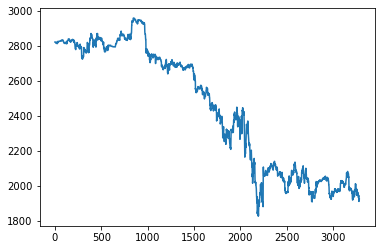

In [2]:
plt.plot(df_rounds[7]['price'])
print(df_rounds[7]['price'].max())
print(df_rounds[7]['price'].min())

In [13]:
starting_sUSD_ETH= [10.66*1000000, 24.83*1000000, 30.0*1000000, 19.7*1000000, 27.4*1000000, 21.2*1000000, 20.6 * 1000000, 20.56 * 1000000]
starting_sUSD_SOL =[304100, 4.98*1000000, 1.48 *1000000, 2.92 * 1000000]
starting_sUSD_LINK = [2.45*1000000, 5.22*1000000, 4.25*1000000, 4.17*1000000, 3.33*1000000, 2.76*1000000, 1.5*1000000, 1.74*1000000] 
starting_sUSDs = {"sETHnew": starting_sUSD_ETH, "sBTCnew": starting_sUSD_BTC, "sLINKnew": starting_sUSD_LINK, 'sSOLnew': starting_sUSD_SOL}

pnls_real_ETH  = [-2.074,.001,-.626,-.7,.36,2.55, -1.894,-7.74]
pnls_real_BTC = [-0.586, -0.1164, -0.2137, -0.3414, 0.667, 1.185]
pnls_real_LINK = [-1.906, -2.48, 2.846, -4.5, 0.834, 0.0713, -0.0616, -.472]
pnls_real_SOL = [+1.038, +0.1855, 0.631, -5.4]
pnls_reals = {"sETHnew": pnls_real_ETH, "sBTCnew": pnls_real_BTC, "sLINKnew": pnls_real_LINK, 'sSOLnew': pnls_real_SOL}

In [4]:
all_pnls = all_rounds_combiner(df_rounds, ASSET, len(df_rounds))

In [6]:
from AMM_Profit_Functions import * 
hedge_Freq = 16.0;
hedged_pnl_percents = []
unhedged_pnl_percents = []

prems_received = []

pnl_trading = []

collateral_pnl = []

SNXFEES = []

hedging_fees = []
hedge_pnls = []

UH_deltas = []
H_deltas = []

TIMES = []

FREELIQS = []

HEDGE_TIMES = []

COLLATS = [];

for j in range(0,len(all_pnls[1])):
    print(j)
    All_Collat_Pos_Data = TimeSeriesInstantMaker(df_rounds[j])
    collat_df = Collat_TimeSeries(All_Collat_Pos_Data,df_rounds[j],ASSET)
    premiums_df = Round_Analyser_Fees(df_rounds[j], ASSET)
    LIQ = starting_sUSDs[ASSET][j]
    trading_pnl = all_pnls[1][j][0]
    hedging_pnl, post_hedge, error_dt, hedge_times = Hedge(df_rounds[j], collat_df, LIQ , ASSET, 0, hedge_freq = hedge_Freq)
    hedge_fees = post_hedge['SNXhedgefees'].sum()
    unhedge_pnl = all_pnls[1][j][0]
    new_pnl = unhedge_pnl + hedging_pnl - hedge_fees
    new_pnl_percent = 100*new_pnl/(LIQ)
    hedged_pnl_percents.append(new_pnl_percent)
    unhedged_pnl_percents.append(all_pnls[0][j])
    
    COLLATS.append(collat_df['BaseCollateral'])
    prems_received.append(all_pnls[1][j][1][0])
    pnl_trading.append(all_pnls[1][j][1][1])
    collateral_pnl.append(all_pnls[1][j][1][2])
    SNXFEES.append(all_pnls[1][j][1][3])
    hedging_fees.append(hedge_fees)
    hedge_pnls.append(hedging_pnl)
    UH_deltas.append(post_hedge['netDelta_no_hedge'])
    H_deltas.append(post_hedge['hedgedDelta'])
    TIMES.append(post_hedge['times'])
    HEDGE_TIMES.append(hedge_times)
    
    FREELIQS.append(post_hedge['FREELIQ'])

0
1
2
3
4
5
6
7


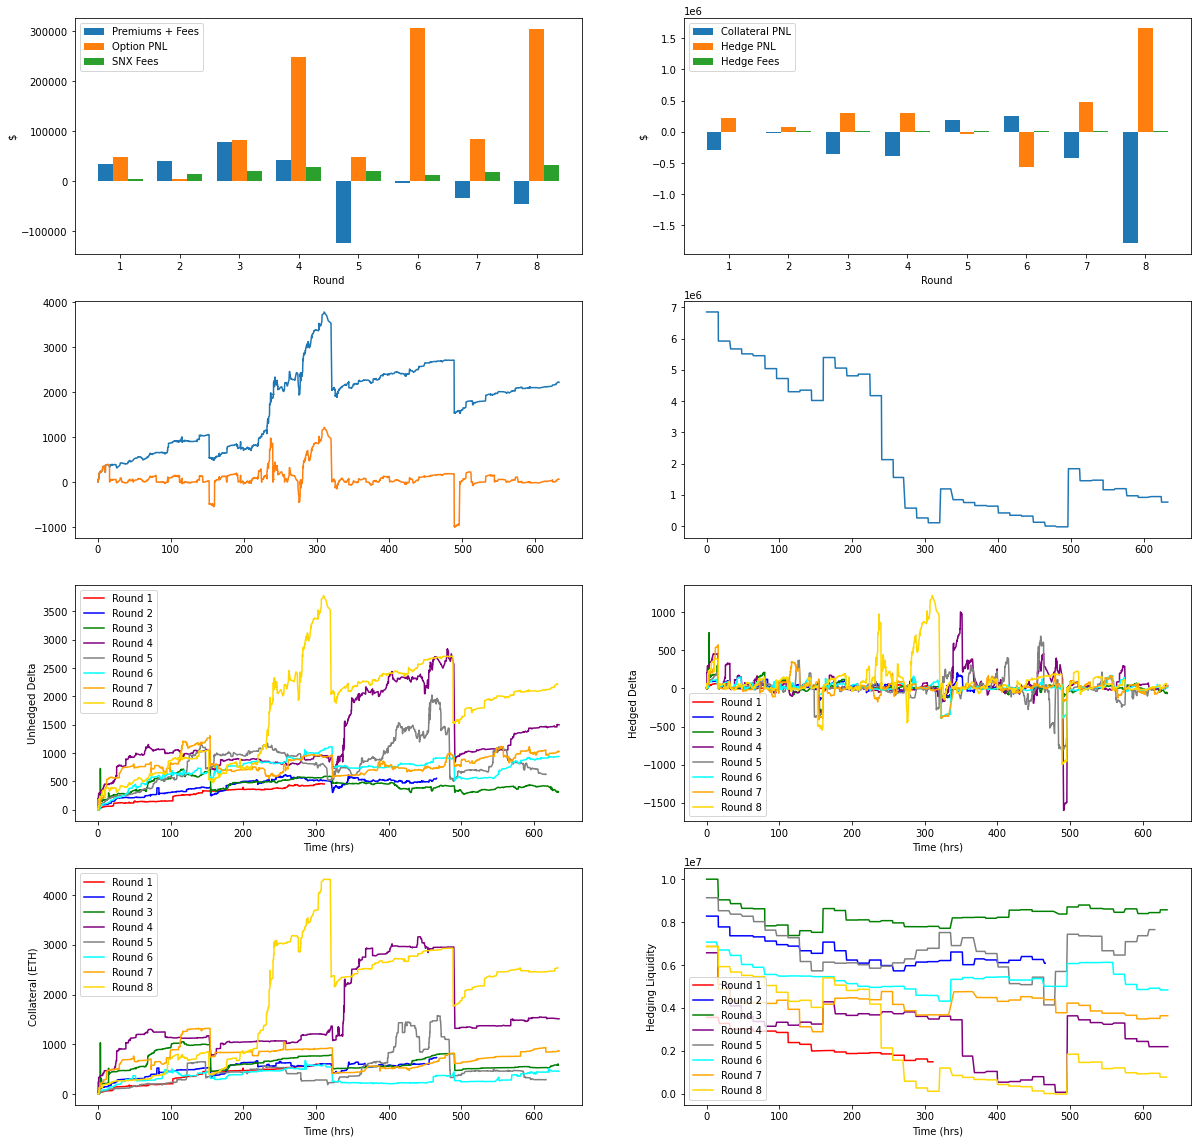

In [7]:
round_plot = np.arange(len(all_pnls[1]))+1
fig, axs = plt.subplots(4,2, figsize=(20,20))
chosen_round = 7;

axs[0,0].bar(round_plot-.25, prems_received,width=0.25, label = 'Premiums + Fees')
axs[0,0].bar(round_plot,pnl_trading,width=0.25, label = 'Option PNL')
axs[0,0].bar(round_plot+0.25, SNXFEES, width = 0.25, label = "SNX Fees")
axs[0,0].legend(loc="upper left")
axs[0,0].set_xlabel("Round")
axs[0,0].set_ylabel("$")
axs[0,1].bar(round_plot-0.25,collateral_pnl,width=0.25, label = 'Collateral PNL')
axs[0,1].bar(round_plot,hedge_pnls,width=0.25, label = 'Hedge PNL')
axs[0,1].bar(round_plot+0.25,hedging_fees,width=0.25, label = 'Hedge Fees')
axs[0,1].legend(loc ='upper left')
axs[0,1].set_xlabel("Round")
axs[0,1].set_ylabel("$")
axs[1,0].plot(TIMES[chosen_round], UH_deltas[chosen_round])
axs[1,0].plot(TIMES[chosen_round], H_deltas[chosen_round])
#for hedge_T in HEDGE_TIMES[chosen_round]:
#    axs[1,0].axvline(x=hedge_T)

cols = ['red', 'blue', 'green', 'purple', 'grey','cyan', 'orange', 'gold'];

for i in range(0,8):
    axs[2,0].plot(TIMES[i], UH_deltas[i], color = cols[i], label = 'Round {}'.format(i+1))
    axs[2,0].legend(loc="upper left")
    
    axs[2,0].set_xlabel("Time (hrs)")
    axs[2,0].set_ylabel("Unhedged Delta")
for i in range(0,8):
    axs[2,1].plot(TIMES[i], H_deltas[i], color = cols[i], label = 'Round {}'.format(i+1))
    axs[2,1].legend(loc="lower left")
    axs[2,1].set_xlabel("Time (hrs)")
    axs[2,1].set_ylabel("Hedged Delta")
for i in range(0,8):
    axs[3,1].plot(TIMES[i], FREELIQS[i], color = cols[i],label = 'Round {}'.format(i+1))
    axs[3,1].legend(loc="lower left")
    axs[3,1].set_xlabel("Time (hrs)")
    axs[3,1].set_ylabel("Hedging Liquidity")
    
for i in range(0,8):
    axs[3,0].plot(TIMES[i], COLLATS[i], color = cols[i],label = 'Round {}'.format(i+1))
    axs[3,0].legend(loc="upper left")
    axs[3,0].set_xlabel("Time (hrs)")
    axs[3,0].set_ylabel("Collateral (ETH)")
axs[1,1].plot(TIMES[chosen_round], FREELIQS[chosen_round])

In [ ]:
from AMM_Profit_Functions import * 
hedge_Freqs = [3.0, 6.0, 8.0, 12.0, 16.0, 24.0, 48.0];
FREQS_hedge_pnl = [];
for kk in range(0,len(hedge_Freqs)): 
    FREQ = hedge_Freqs[kk]
    print(FREQ)
    hedged_pnl_percents = []
    unhedged_pnl_percents = []

    prems_received = []

    pnl_trading = []

    collateral_pnl = []

    SNXFEES = []

    hedging_fees = []
    hedge_pnls = []

    UH_deltas = []
    H_deltas = []

    TIMES = []

    FREELIQS = []

    HEDGE_TIMES = []

    

    for i in range(0,len(all_pnls[1])):
        All_Collat_Pos_Data = TimeSeriesInstantMaker(df_rounds[i])
        collat_df = Collat_TimeSeries(All_Collat_Pos_Data,df_rounds[i],ASSET)
        premiums_df = Round_Analyser_Fees(df_rounds[i], ASSET)
        LIQ = starting_sUSDs[ASSET][i]
        trading_pnl = all_pnls[1][i][0]
        hedging_pnl, post_hedge, error_dt, hedge_times = Hedge(df_rounds[i], collat_df, LIQ , ASSET, 0, hedge_freq = FREQ)
        hedge_fees = post_hedge['SNXhedgefees'].sum()
        unhedge_pnl = all_pnls[1][i][0]
        new_pnl = unhedge_pnl + hedging_pnl - hedge_fees
        new_pnl_percent = 100*new_pnl/(LIQ)
        hedged_pnl_percents.append(new_pnl_percent)
         
        prems_received.append(all_pnls[1][i][1][0])
        pnl_trading.append(all_pnls[1][i][1][1])
        collateral_pnl.append(all_pnls[1][i][1][2])
        SNXFEES.append(all_pnls[1][i][1][3])
        hedging_fees.append(hedge_fees)
        hedge_pnls.append(hedging_pnl)
        UH_deltas.append(post_hedge['netDelta_no_hedge'])
        H_deltas.append(post_hedge['hedgedDelta'])
        TIMES.append(post_hedge['times'])
        HEDGE_TIMES.append(hedge_times)
    
        FREELIQS.append(post_hedge['FREELIQ'])
        
    FREQS_hedge_pnl.append(hedged_pnl_percents)
        
        

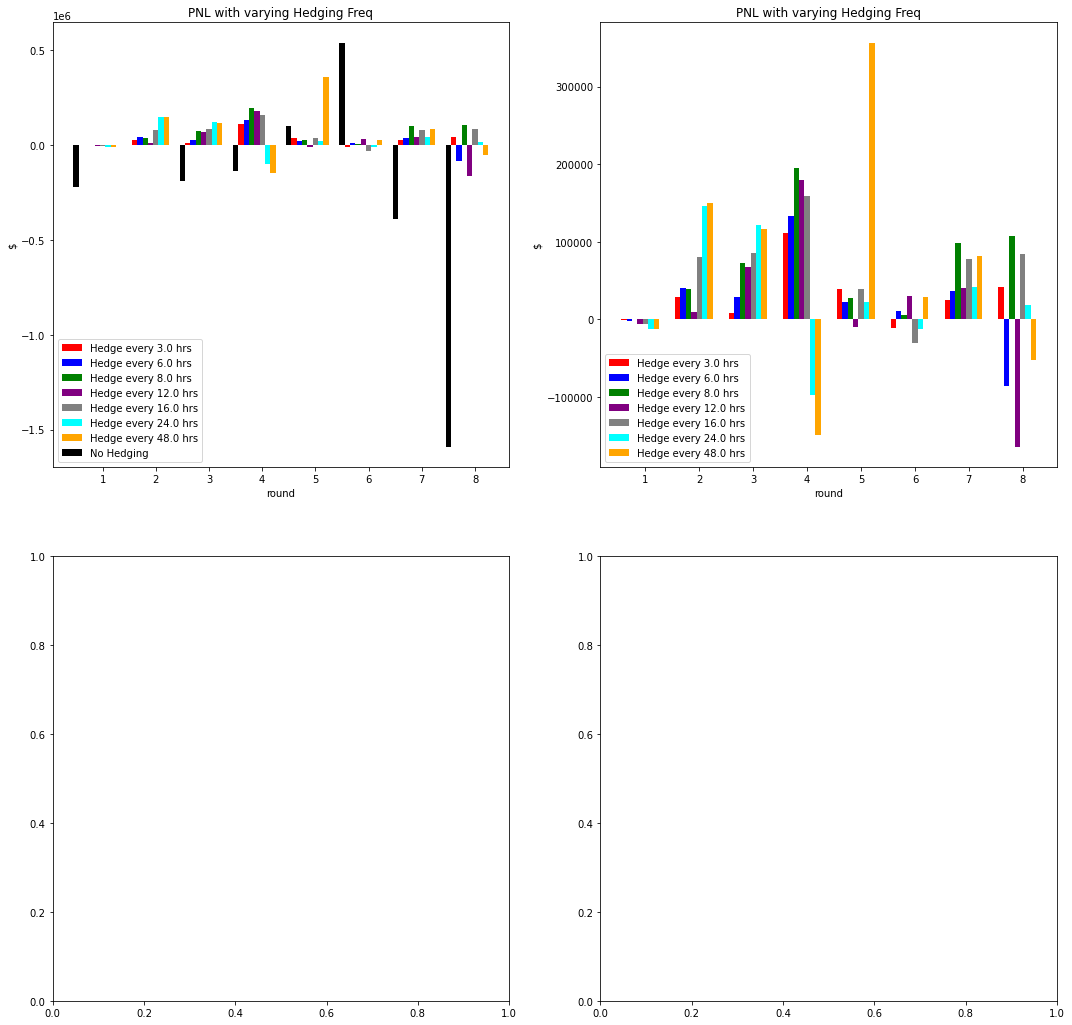

In [17]:
FREQS_hedge_pnl;
rounds = np.arange(8)+1 #CHANGE HERE FOR SOL
cols = ['red', 'blue', 'green', 'purple', 'grey','cyan', 'orange', 'yellow'];
fig, axs = plt.subplots(2,2, figsize=(18,18))
for i in range(0, len(FREQS_hedge_pnl)):
    axs[0,0].bar(rounds-(4-i)*0.1,np.array(FREQS_hedge_pnl[i])*starting_sUSDs[ASSET]/100, width = 0.1, color = cols[i],label = 'Hedge every {} hrs'.format(hedge_Freqs[i]))
axs[0,0].bar(rounds - 5*0.1, np.array(pnls_reals[ASSET])*starting_sUSDs[ASSET]/100, width = 0.1, color = 'black', label = 'No Hedging')
axs[0,0].set_xlabel("round")
axs[0,0].set_ylabel("$")
axs[0,0].legend(loc="lower left")
axs[0,0].title.set_text('PNL with varying Hedging Freq')

for i in range(0, len(FREQS_hedge_pnl)):
    axs[0,1].bar(rounds-(4-i)*0.1,np.array(FREQS_hedge_pnl[i])*starting_sUSDs[ASSET]/100, width = 0.1, color = cols[i],label = 'Hedge every {} hrs'.format(hedge_Freqs[i]))
axs[0,1].set_xlabel("round")
axs[0,1].set_ylabel("$")
axs[0,1].legend(loc="lower left")
axs[0,1].title.set_text('PNL with varying Hedging Freq')


In [12]:
len(pnls_reals[ASSET])

6